In [1]:
# === LOAD REAL & SYNTHETIC DATA ===
import pandas as pd

# Path to your CSV files
real_path  = "bean-clean.csv"          # real dataset
synth_path = "merged_syn_data.csv"     # synthetic dataset generated by CTGAN

# Load them
real_df  = pd.read_csv(real_path)
synth_df = pd.read_csv(synth_path)

# Quick sanity check
print(f"Real data: {real_df.shape} | Synthetic data: {synth_df.shape}")
display(real_df.head(3))
display(synth_df.head(3))


Real data: (7429, 17) | Synthetic data: (2500, 17)


Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  28395    610.291       208.178117       173.888747      1.197191   
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027   
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.913358      0.007332      0.003147      0.834222      0.998724  SEKER  
1     0.953861      0.006979      0.003564      0.909851      0.998430  SEKER  
2     0.908774      0.007244      0.003048      0.825871      0.999066  SEKER

Area   Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  53960.651518  667.281549       228.430986       189.193128      1.088423   
1  41858.093224  705.145839       232.412402       179.662260      1.028711   
2  40771.376544  719.324519       198.304288       215.037361      1.120313   

   Eccentricity    ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
0      0.556140  28494.544085     182.034239  0.770191  0.988434   0.964509   
1      0.414037  39793.112911     191.920294  0.771724  0.985837   0.950164   
2      0.639776  30133.007026     227.428541  0.719812  0.991986   0.969438   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  Class  
0     0.852371      0.007457     -0.000711      0.756895      0.995221  SEKER  
1     0.893964      0.007538      0.001545      0.655500      0.999014  SEKER  
2     0.873109      0.008372      0.001801      0.732558      0.996018  SEKER

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", lambda v: f"{v:0.3f}")
sns.set_style("whitegrid")

def get_numeric_cols(df, drop_labels=('Class', 'label', 'Labels', 'Target', 'target')):
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # Drop common label columns if they slipped in as numeric encodings
    for c in drop_labels:
        if c in cols:
            cols.remove(c)
    return cols

def align_columns(real_df, synth_df):
    # Use intersection of numeric columns present in both frames
    num_real = get_numeric_cols(real_df)
    num_syn  = get_numeric_cols(synth_df)
    common   = [c for c in num_real if c in num_syn]
    if not common:
        raise ValueError("No common numeric columns found between real_df and synth_df.")
    return real_df[common].copy(), synth_df[common].copy()

real_num, synth_num = align_columns(real_df, synth_df)
print(f"Using {len(real_num.columns)} numeric features:", list(real_num.columns))


Using 16 numeric features: ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4']


In [3]:
ks_rows = []
for col in real_num.columns:
    stat, p = ks_2samp(real_num[col].values, synth_num[col].values)
    ks_rows.append({"feature": col, "ks_stat": stat, "p_value": p})

ks_df = pd.DataFrame(ks_rows).sort_values("ks_stat")
display(ks_df)


feature  ks_stat  p_value
4      AspectRation    0.068    0.000
5      Eccentricity    0.074    0.000
11      Compactness    0.082    0.000
10        roundness    0.094    0.000
8            Extent    0.107    0.000
14     ShapeFactor3    0.136    0.000
6        ConvexArea    0.138    0.000
2   MajorAxisLength    0.140    0.000
15     ShapeFactor4    0.143    0.000
9          Solidity    0.154    0.000
3   MinorAxisLength    0.187    0.000
7     EquivDiameter    0.201    0.000
0              Area    0.216    0.000
12     ShapeFactor1    0.236    0.000
1         Perimeter    0.252    0.000
13     ShapeFactor2    0.326    0.000

In [4]:
w_rows = []
for col in real_num.columns:
    w = wasserstein_distance(real_num[col].values, synth_num[col].values)
    w_rows.append({"feature": col, "wasserstein": w})

wasser_df = pd.DataFrame(w_rows).sort_values("wasserstein")
display(wasser_df)


feature  wasserstein
13     ShapeFactor2        0.001
12     ShapeFactor1        0.001
15     ShapeFactor4        0.001
9          Solidity        0.002
8            Extent        0.011
10        roundness        0.013
11      Compactness        0.013
5      Eccentricity        0.018
14     ShapeFactor3        0.032
4      AspectRation        0.050
7     EquivDiameter       25.272
3   MinorAxisLength       25.659
2   MajorAxisLength       45.567
1         Perimeter      116.003
0              Area    16217.531
6        ConvexArea    17976.725

In [5]:
corr_real  = real_num.corr()
corr_synth = synth_num.corr()

# Mean Absolute Correlation Difference across all pairs
macd = np.mean(np.abs(corr_real.values - corr_synth.values))
print(f"Mean Absolute Correlation Difference (MACD): {macd:0.3f}")

# Optional: per-feature average absolute correlation diff (how well each feature's correlations were preserved)
per_feat_macd = (np.abs(corr_real - corr_synth)).mean(axis=1).sort_values()
per_feat_macd = per_feat_macd.rename("mean_abs_corr_diff").to_frame()
display(per_feat_macd)


Mean Absolute Correlation Difference (MACD): 0.202


mean_abs_corr_diff
Area                          0.114
ConvexArea                    0.115
MinorAxisLength               0.115
Perimeter                     0.124
EquivDiameter                 0.134
Extent                        0.147
ShapeFactor1                  0.167
MajorAxisLength               0.176
AspectRation                  0.206
ShapeFactor4                  0.208
Compactness                   0.212
roundness                     0.228
Eccentricity                  0.229
ShapeFactor3                  0.239
Solidity                      0.287
ShapeFactor2                  0.530

In [7]:
cov_rows = []
for col in real_num.columns:
    rmin, rmax = real_num[col].min(), real_num[col].max()
    syn_vals = synth_num[col].values
    within = np.mean((syn_vals >= rmin) & (syn_vals <= rmax)) * 100.0
    var_ratio = (np.var(syn_vals, ddof=1) / np.var(real_num[col].values, ddof=1)) if np.var(real_num[col].values, ddof=1) > 0 else np.nan
    cov_rows.append({"feature": col, "coverage_percent": within, "variance_ratio": var_ratio})

coverage_df = pd.DataFrame(cov_rows).sort_values("coverage_percent", ascending=False)
display(coverage_df)

print(f"\nAverage coverage %: {coverage_df['coverage_percent'].mean():0.2f}")
print(f"Average variance ratio: {coverage_df['variance_ratio'].mean():0.3f}")


feature  coverage_percent  variance_ratio
10        roundness           100.000           0.727
0              Area            99.880           1.649
4      AspectRation            99.800           1.219
14     ShapeFactor3            99.720           0.756
11      Compactness            99.680           0.944
3   MinorAxisLength            99.440           2.401
5      Eccentricity            99.440           1.338
7     EquivDiameter            99.400           1.528
8            Extent            97.360           1.431
9          Solidity            97.040           1.563
1         Perimeter            96.120           1.540
6        ConvexArea            95.920           2.927
2   MajorAxisLength            94.600           2.535
15     ShapeFactor4            87.000           1.442
12     ShapeFactor1            81.960           4.604
13     ShapeFactor2            61.120           5.730


Average coverage %: 94.28
Average variance ratio: 2.021


In [8]:
summary = (ks_df.merge(wasser_df, on="feature")
                .merge(coverage_df, on="feature")
                .merge(per_feat_macd.reset_index().rename(columns={"index":"feature"}), on="feature"))
summary = summary[["feature", "ks_stat", "p_value", "wasserstein", "coverage_percent", "variance_ratio", "mean_abs_corr_diff"]]
display(summary.sort_values(["ks_stat", "wasserstein"]))


feature  ks_stat  p_value  wasserstein  coverage_percent  \
0      AspectRation    0.068    0.000        0.050            99.800   
1      Eccentricity    0.074    0.000        0.018            99.440   
2       Compactness    0.082    0.000        0.013            99.680   
3         roundness    0.094    0.000        0.013           100.000   
4            Extent    0.107    0.000        0.011            97.360   
5      ShapeFactor3    0.136    0.000        0.032            99.720   
6        ConvexArea    0.138    0.000    17976.725            95.920   
7   MajorAxisLength    0.140    0.000       45.567            94.600   
8      ShapeFactor4    0.143    0.000        0.001            87.000   
9          Solidity    0.154    0.000        0.002            97.040   
10  MinorAxisLength    0.187    0.000       25.659            99.440   
11    EquivDiameter    0.201    0.000       25.272            99.400   
12             Area    0.216    0.000    16217.531            99.880   
13     ShapeFactor1    0.236    0.000        0.001            81.960   
14        Perimeter    0.252    0.000      116.003            96.120   
15     ShapeFactor2    0.326    0.000        0.001            61.120   

    variance_ratio  mean_abs_corr_diff  
0            1.219               0.206  
1            1.338               0.229  
2            0.944               0.212  
3            0.727               0.228  
4            1.431               0.147  
5            0.756               0.239  
6            2.927               0.115  
7            2.535               0.176  
8            1.442               0.208  
9            1.563               0.287  
10           2.401               0.115  
11           1.528               0.134  
12           1.649               0.114  
13           4.604               0.167  
14           1.540               0.124  
15           5.730               0.530

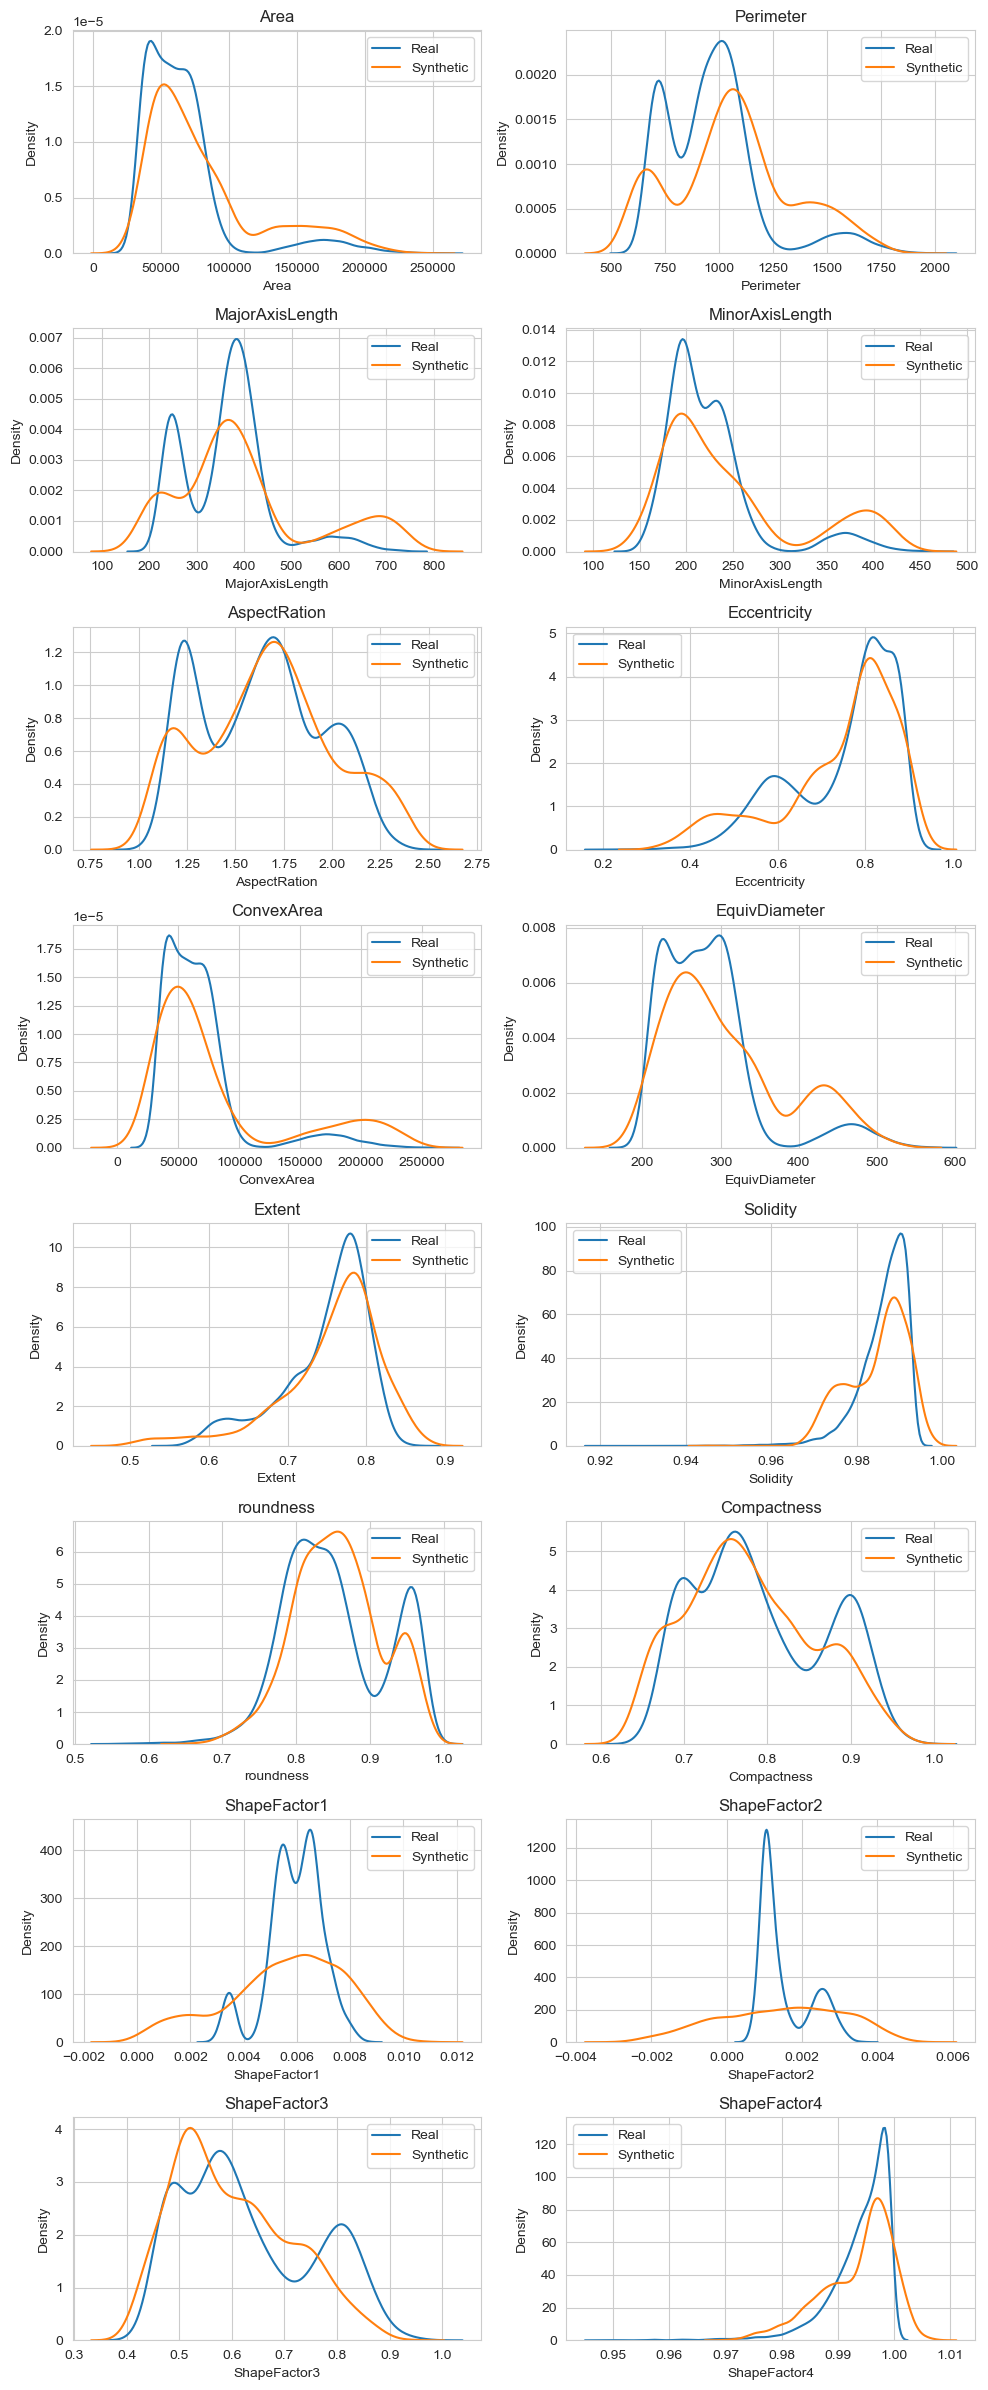

In [9]:
ncols = 2
nrows = int(np.ceil(len(real_num.columns)/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3*nrows))
axes = axes.ravel()

for i, col in enumerate(real_num.columns):
    ax = axes[i]
    sns.kdeplot(real_num[col], ax=ax, label="Real", fill=False)
    sns.kdeplot(synth_num[col], ax=ax, label="Synthetic", fill=False)
    ax.set_title(col)
    ax.legend()

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


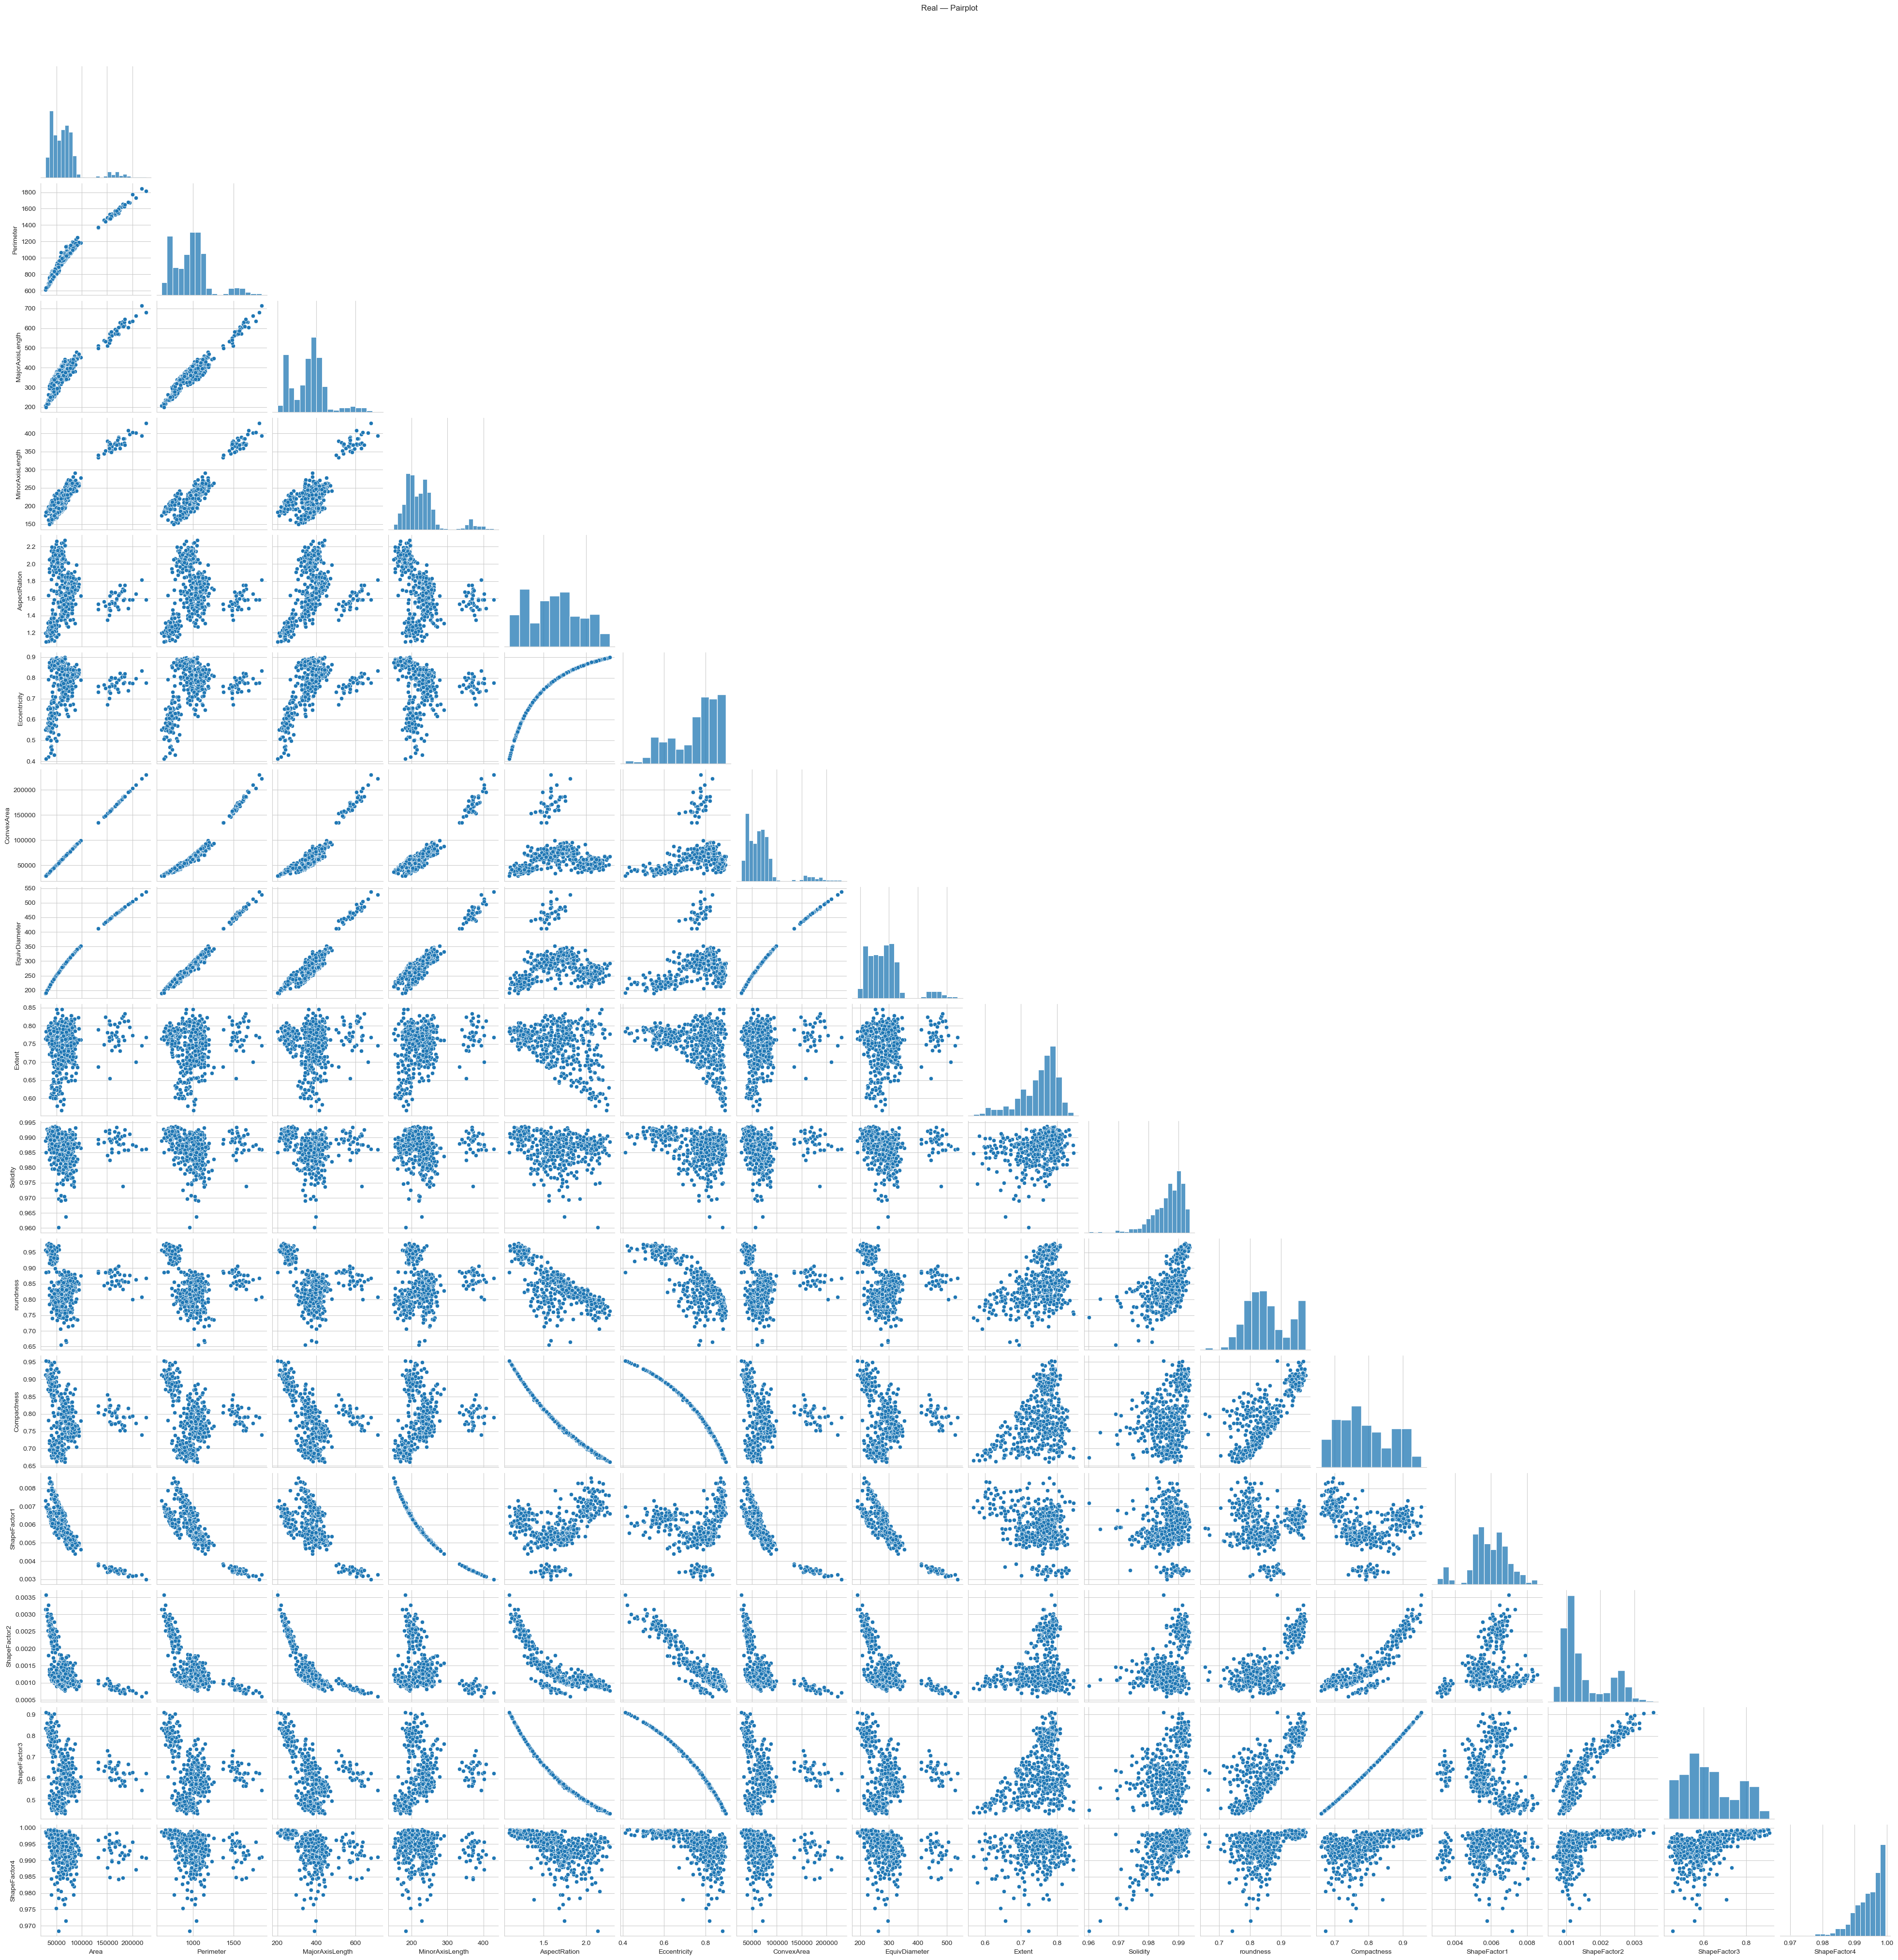

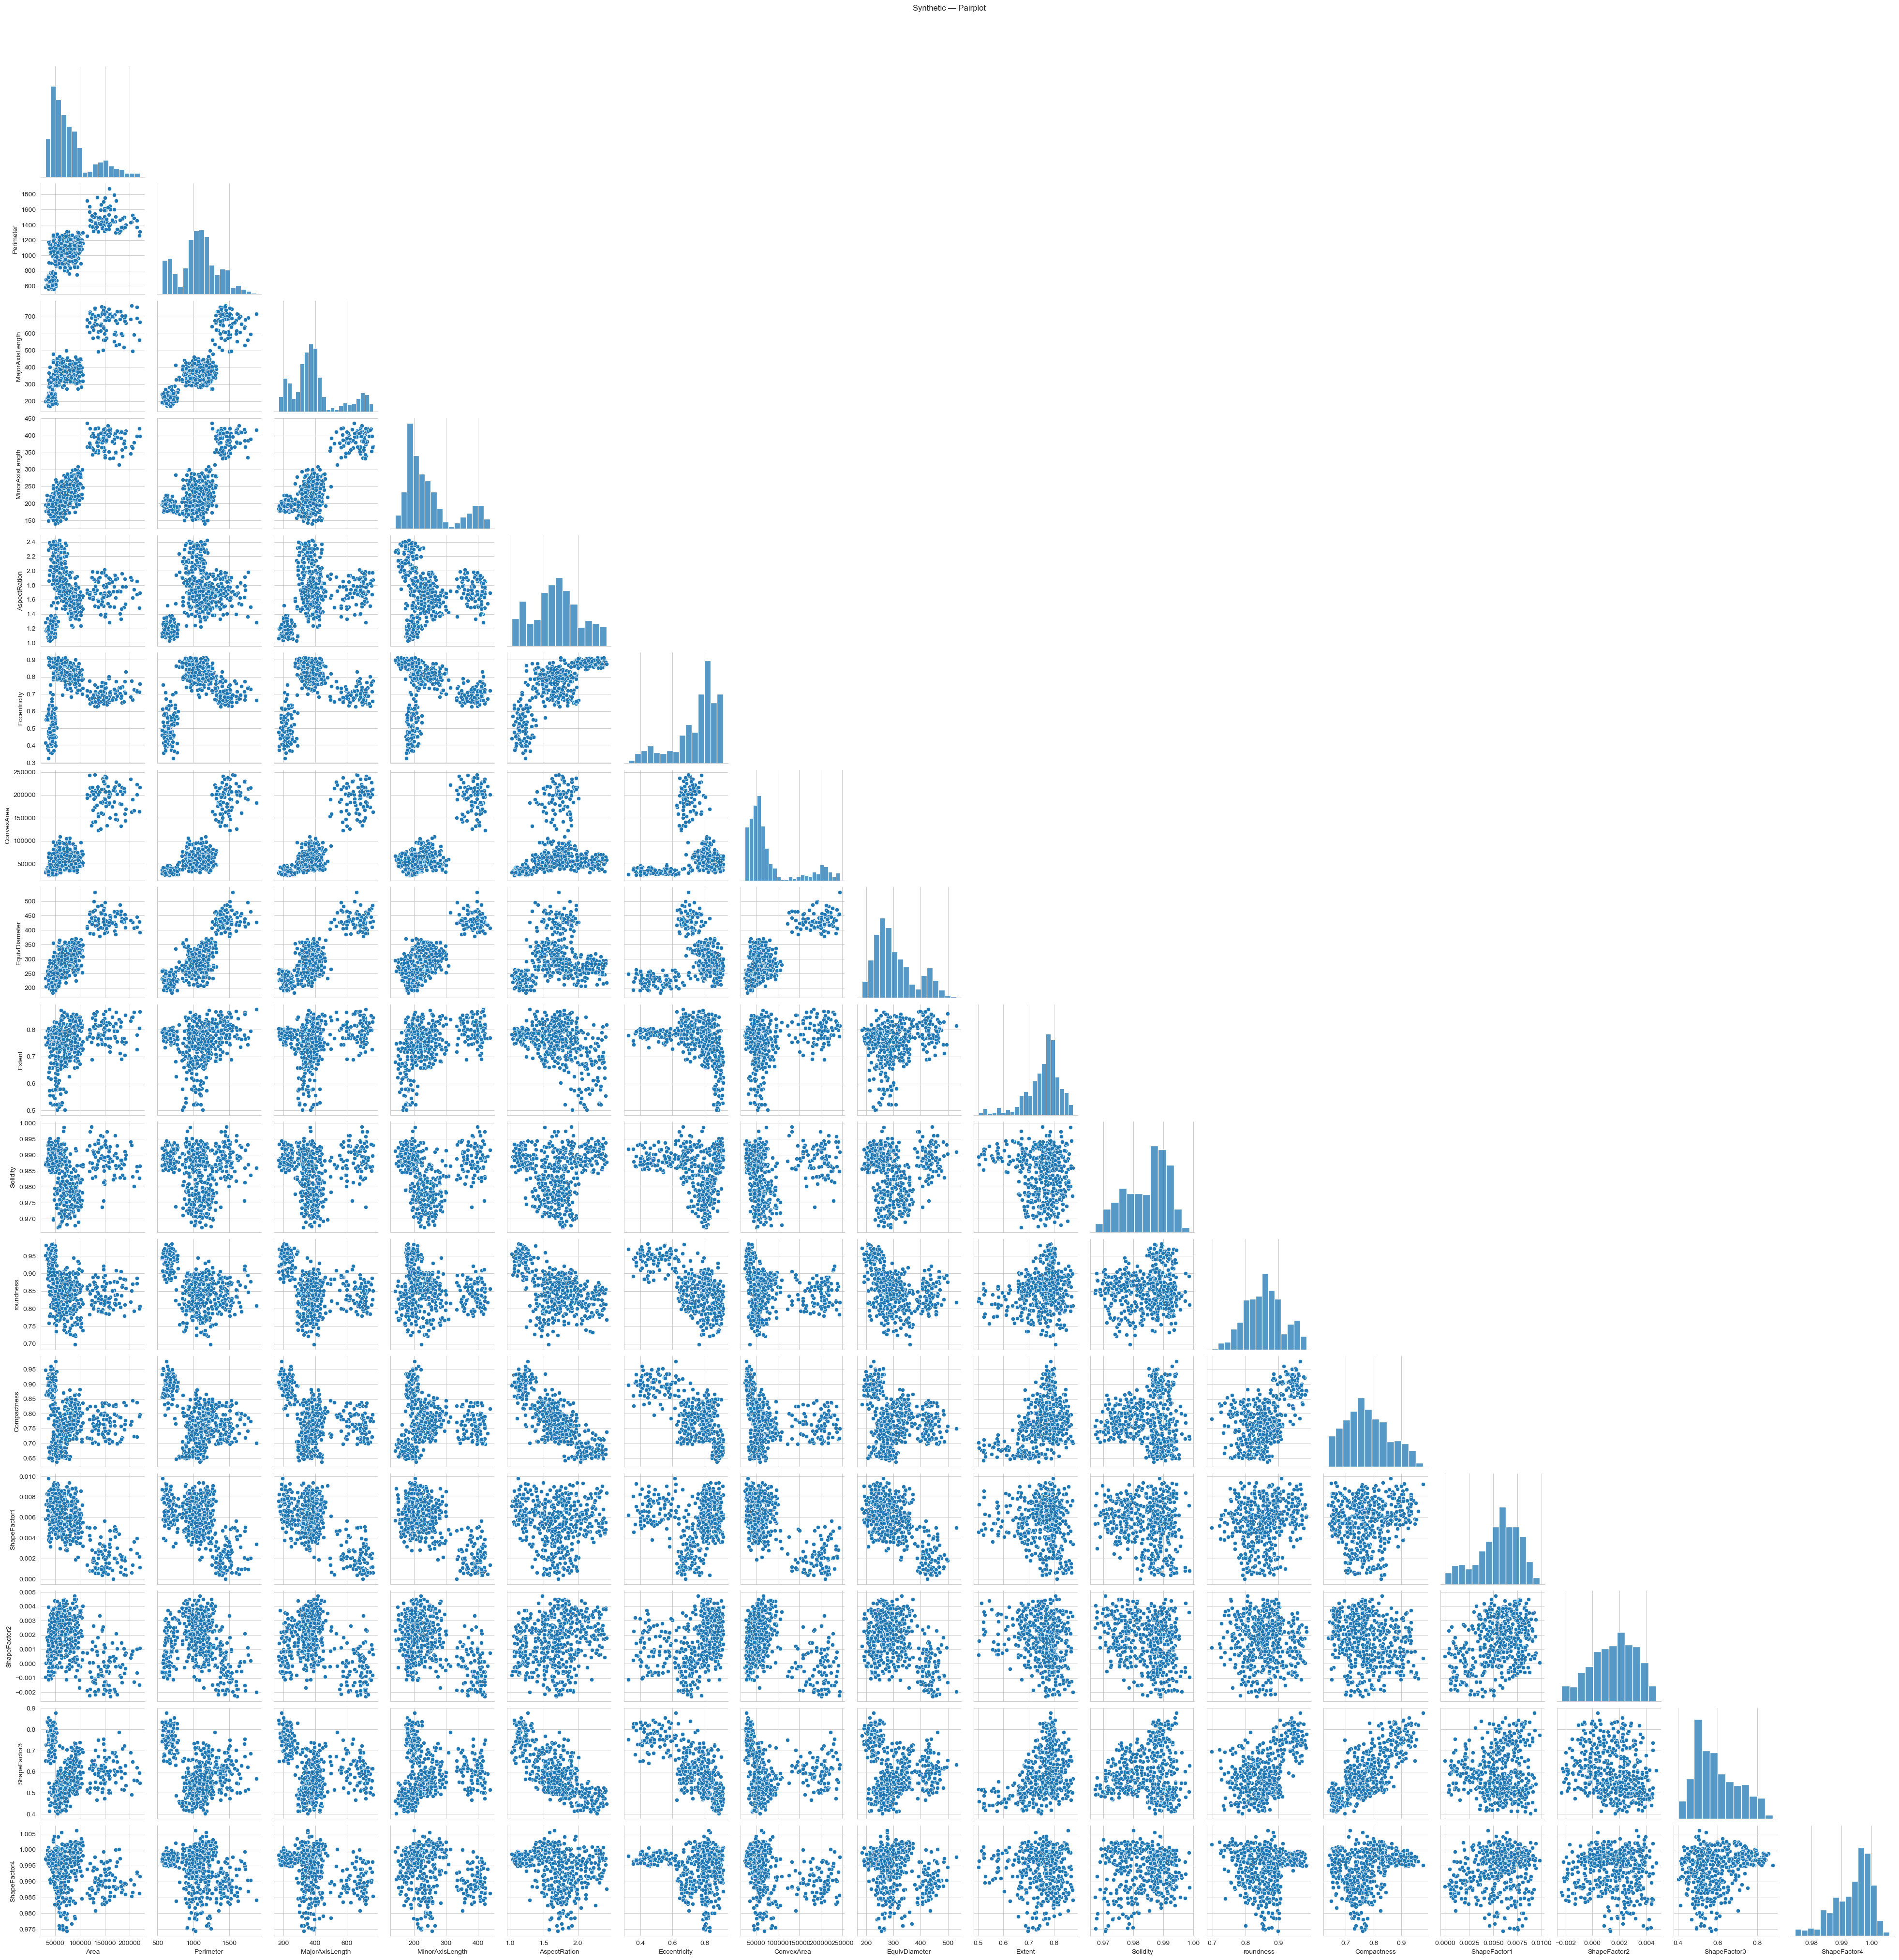

In [10]:
# If you keep a 'Class' column outside real_num/synth_num, you can merge it back temporarily for hue.
# Here we do pairplots without hue to remain general.
sns.pairplot(real_num.sample(min(len(real_num), 500)), corner=True)
plt.suptitle("Real — Pairplot", y=1.02)
plt.show()

sns.pairplot(synth_num.sample(min(len(synth_num), 500)), corner=True)
plt.suptitle("Synthetic — Pairplot", y=1.02)
plt.show()


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(corr_real,  vmin=-1, vmax=1, cmap="vlag", center=0, ax=axes[0])
axes[0].set_title("Real: Correlation Matrix")
sns.heatmap(corr_synth, vmin=-1, vmax=1, cmap="vlag", center=0, ax=axes[1])
axes[1].set_title("Synthetic: Correlation Matrix")
plt.tight_layout()
plt.show()


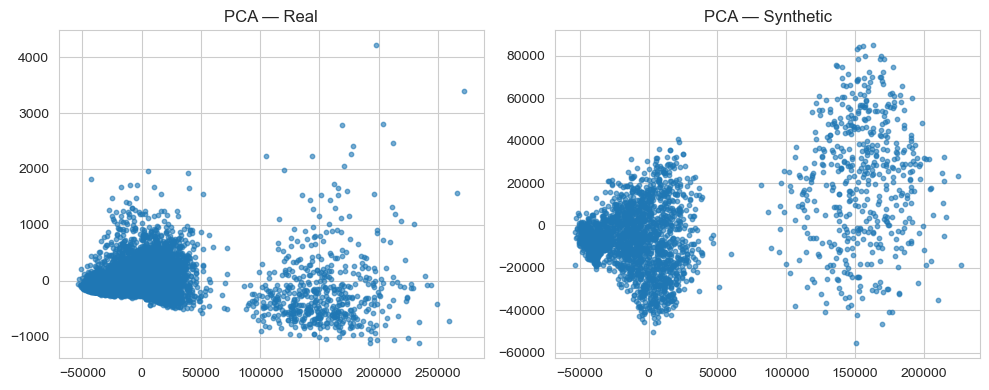

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2, random_state=42)
p_real  = pca.fit_transform(real_num.values)
p_synth = pca.transform(synth_num.values)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(p_real[:,0],  p_real[:,1],  s=10, alpha=0.6)
ax[0].set_title("PCA — Real")
ax[1].scatter(p_synth[:,0], p_synth[:,1], s=10, alpha=0.6)
ax[1].set_title("PCA — Synthetic")
plt.tight_layout()
plt.show()

# t-SNE (note: slower; you can reduce perplexity or samples if needed)
tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=42)
ts_real  = tsne.fit_transform(real_num.values)
ts_synth = tsne.fit_transform(synth_num.values)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(ts_real[:,0],  ts_real[:,1],  s=10, alpha=0.6)
ax[0].set_title("t-SNE — Real")
ax[1].scatter(ts_synth[:,0], ts_synth[:,1], s=10, alpha=0.6)
ax[1].set_title("t-SNE — Synthetic")
plt.tight_layout()
plt.show()
